In [67]:
import pandas as pd
df = pd.read_excel('../../data_set/hd_sessions/cleaned_session_data.xlsx')

# 2. Create the target: Next session's dry weight - current dry weight
df['Next Dry weight (kg)'] = df.groupby('Subject_ID')['Dry weight (kg)'].shift(-1)
df['Dry weight adjustment (kg)'] = df['Next Dry weight (kg)'] - df['Dry weight (kg)']


# 3. Drop rows where the target is NaN (i.e., last session for a patient)
df = df.dropna(subset=['Dry weight adjustment (kg)']).reset_index(drop=True)

#ensure the dry weight adjustment is between -10 and 10 kg
df = df[(df['Dry weight adjustment (kg)'] >= -10) & (df['Dry weight adjustment (kg)'] <= 10)]

#save the cleaned dataframe to a new file
df.to_excel('../../data_set/hd_sessions/cleaned_session_data_with_target.xlsx', index=False)

# Rule 1: SBP > 140
df['High_SBP'] = df['SYS (mmHg)'] > 140

# Rule 2: No IDH - Placeholder (need real IDH indicator if available)
# For now, we assume no IDH if DIA remains above 60 mmHg
#df['No_IDH'] = df['DIA (mmHg)'] > 60

# Rule 3: UFR < 15 ml/kg/hr
df['UFR'] = df['PUF (ml)'] / (df['HD duration (h)'] * df['Pre HD weight (kg)'])
df['UFR_below_15'] = df['UFR'] < 15

# Combine into DW adjustment rules
# df['DW_Decrease_Eligible'] = df['High_SBP'] & df['No_IDH'] & df['UFR_below_15']
# df['DW_Increase_Eligible'] = (~df['High_SBP']) & df['No_IDH'] & df['UFR_below_15']

# # Optional: Make DW adjustment suggestion
# df['DW_Adjustment_Suggestion'] = np.select(
#     [
#         df['DW_Decrease_Eligible'],
#         df['DW_Increase_Eligible']
#     ],
#     [
#         -0.5,  # decrease DW
#         +0.5   # increase DW
#     ],
#     default=0  # no change
# )


def get_adjustment_class(row):
    diff = row['Next Dry weight (kg)'] - row['Dry weight (kg)']
    if abs(diff) > 0:
        return 1
    else:
        return 0

df['Adjustment_Class'] = df.apply(get_adjustment_class, axis=1)

print("Class Distribution:\n", df['Adjustment_Class'].value_counts())

#print  first 10 rows of the dataframe
print(df.head(5))


Class Distribution:
 Adjustment_Class
0    3497
1     311
Name: count, dtype: int64
    Subject_ID Session_No       Date  AP (mmHg)  AUF (ml)  BFR (ml/min)  \
0  RHD_THP_001  Session 1 2024-02-01     -143.0    1000.0         200.0   
1  RHD_THP_001  Session 2 2024-05-01     -164.0    3300.0         180.0   
2  RHD_THP_001  Session 3 2024-09-01     -166.0    3000.0         200.0   
3  RHD_THP_001  Session 4 2024-12-01     -142.0    3300.0         250.0   
4  RHD_THP_001  Session 5 2024-01-16     -126.0    2000.0         250.0   

   Dry weight (kg)  HD duration (h)  PUF (ml)  Post HD weight (kg)  ...  \
0             68.5                4    1600.0                 68.5  ...   
1             68.5                4    3300.0                 68.4  ...   
2             68.5                4    3000.0                 68.7  ...   
3             68.5                4    3300.0                 68.7  ...   
4             68.5                4    2000.0                 68.5  ...   

   VP (mmHg)  

In [41]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE
import xgboost as xgb
from sklearn.utils.class_weight import compute_class_weight

# Features and target columns
features = [
    'AP (mmHg)', 'AUF (ml)', 'BFR (ml/min)', 'Dry weight (kg)', 'HD duration (h)', 'High_SBP', 'UFR', 'UFR_below_15',
    'PUF (ml)', 'Post HD weight (kg)', 'Pre HD weight (kg)', 'TMP (mmHg)',
    'VP (mmHg)', 'Weight gain (kg)', 'SYS (mmHg)', 'DIA (mmHg)'
]

# Assuming your dataframe is df and target column is 'Adjustment_Class'
X = df[features]
y = df['Adjustment_Class']

# Encode target classes
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# Train-test split with stratify to keep distribution
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

# Compute class weights from training set
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
weights_dict = {i: w for i, w in enumerate(class_weights)}

# Apply SMOTE to training data
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Calculate sample weights for resampled data
sample_weights_resampled = np.array([weights_dict[label] for label in y_train_resampled])

# Define and train XGBoost classifier
model = xgb.XGBClassifier(
    objective='multi:softprob',
    num_class=len(le.classes_),
    eval_metric='mlogloss',
    use_label_encoder=False,
    random_state=42
)

model.fit(X_train_resampled, y_train_resampled, sample_weight=sample_weights_resampled)

# Predict on test set
y_pred = model.predict(X_test)


# Evaluation
print(classification_report(y_test, y_pred, target_names=[str(cls) for cls in le.classes_]))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))




c:\Users\nandu\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:183: UserWarning: [21:47:14] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


ValueError: Classification metrics can't handle a mix of binary and multilabel-indicator targets

In [16]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, f1_score
import numpy as np

# Define parameter grid for XGBoost
param_grid = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [50, 100, 200],
    'min_child_weight': [1, 3, 5],
    'subsample': [0.7, 1],
    'colsample_bytree': [0.7, 1]
}

# Use macro F1 as scoring metric to balance performance across classes
f1_macro_scorer = make_scorer(f1_score, average='macro')

xgb_clf = xgb.XGBClassifier(
    objective='multi:softprob',
    num_class=len(le.classes_),
    use_label_encoder=False,
    random_state=42
)

grid_search = GridSearchCV(
    estimator=xgb_clf,
    param_grid=param_grid,
    scoring=f1_macro_scorer,
    cv=3,
    verbose=2,
    n_jobs=-1
)

# Fit grid search on resampled training data with sample weights
grid_search.fit(X_train_resampled, y_train_resampled, sample_weight=sample_weights_resampled)

print("Best parameters:", grid_search.best_params_)
print("Best macro F1 score:", grid_search.best_score_)

# Use best estimator for prediction
best_model = grid_search.best_estimator_


Fitting 3 folds for each of 324 candidates, totalling 972 fits


c:\Users\nandu\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:183: UserWarning: [19:16:45] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Best parameters: {'colsample_bytree': 0.7, 'learning_rate': 0.2, 'max_depth': 7, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 1}
Best macro F1 score: 0.9531669523745702


Best thresholds per class: [0.7000000000000002, 0.5000000000000001, 0.1]
Best macro F1 after threshold tuning: 0.4725120055834389
Final Classification Report:

              precision    recall  f1-score   support

           0       0.94      0.88      0.91       700
           1       0.20      0.28      0.23        32
           2       0.13      0.26      0.18        31

    accuracy                           0.83       763
   macro avg       0.42      0.47      0.44       763
weighted avg       0.87      0.83      0.85       763

Final Confusion Matrix:

[[634  18  48]
 [ 21   7   4]
 [ 18   1  12]]


Text(0.5, 1.0, 'Feature Importance')

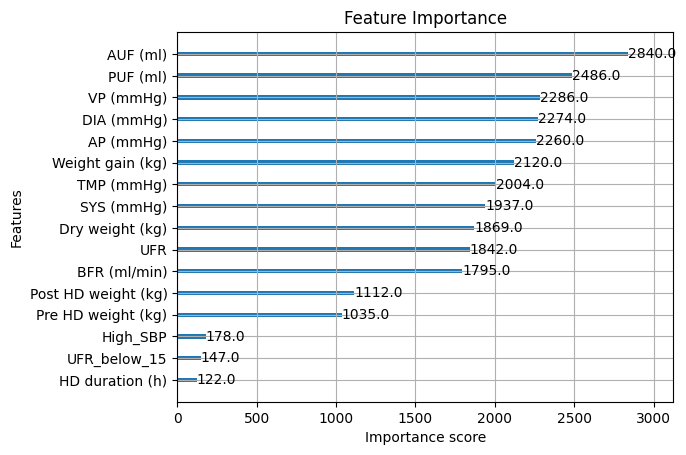

In [18]:
from sklearn.metrics import f1_score

# Predict probabilities on test set
y_probs = best_model.predict_proba(X_test)

# Function to tune thresholds for each class to maximize macro F1
def tune_thresholds(y_true, y_probs, num_classes):
    best_thresholds = [0.5] * num_classes  # start with 0.5 default
    thresholds_range = np.arange(0.1, 0.9, 0.05)
    
    best_macro_f1 = 0
    best_t = best_thresholds.copy()
    
    for t0 in thresholds_range:
        for t1 in thresholds_range:
            for t2 in thresholds_range:
                thresholds = [t0, t1, t2]
                # Predict classes based on thresholds
                y_pred = np.array([
                    np.argmax([y_probs[i, c] if y_probs[i, c] >= thresholds[c] else 0 for c in range(num_classes)])
                    for i in range(len(y_true))
                ])
                f1 = f1_score(y_true, y_pred, average='macro')
                if f1 > best_macro_f1:
                    best_macro_f1 = f1
                    best_t = thresholds.copy()
    return best_t, best_macro_f1

best_thresholds, best_f1 = tune_thresholds(y_test, y_probs, num_classes=len(le.classes_))
print(f"Best thresholds per class: {best_thresholds}")
print(f"Best macro F1 after threshold tuning: {best_f1}")

# Predict final classes using best thresholds
y_pred_final = np.array([
    np.argmax([y_probs[i, c] if y_probs[i, c] >= best_thresholds[c] else 0 for c in range(len(le.classes_))])
    for i in range(len(y_test))
])

# Final evaluation
print("Final Classification Report:\n")
print(classification_report(y_test, y_pred, target_names=[str(cls) for cls in le.classes_]))
print("Final Confusion Matrix:\n")
print(confusion_matrix(y_test, y_pred_final))

#feature importance
import matplotlib.pyplot as plt
import xgboost as xgb
# Plot feature importance   
xgb.plot_importance(best_model, importance_type='weight')
plt.title('Feature Importance')


In [76]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve
from imblearn.ensemble import BalancedRandomForestClassifier
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import seaborn as sns

# Load data
df = pd.read_excel('../../data_set/hd_sessions/cleaned_session_data.xlsx')

# Create target and features
df['Next Dry weight (kg)'] = df.groupby('Subject_ID')['Dry weight (kg)'].shift(-1)
df['Dry weight adjustment (kg)'] = df['Next Dry weight (kg)'] - df['Dry weight (kg)']
df = df.dropna(subset=['Dry weight adjustment (kg)']).reset_index(drop=True)
#ensure the dry weight adjustment is between -10 and 10 kg
df = df[(df['Dry weight adjustment (kg)'] >= -10) & (df['Dry weight adjustment (kg)'] <= 10)]

# Rule-based features
df['High_SBP'] = df['SYS (mmHg)'] > 140
df['UFR'] = df['PUF (ml)'] / (df['HD duration (h)'] * df['Pre HD weight (kg)'])
df['UFR_below_15'] = df['UFR'] < 15

# Binary adjustment class with >=
def get_adjustment_class(row, threshold=0.1):
    diff = row['Next Dry weight (kg)'] - row['Dry weight (kg)']
    if abs(diff) >= threshold:
        return 1
    else:
        return 0

df['Adjustment_Class'] = df.apply(get_adjustment_class, axis=1)
df['Adjustment_Direction'] = df['Dry weight adjustment (kg)'].apply(
    lambda x: 1 if x >= 0.5 else (2 if x <= -0.5 else 0)
)

# Additional features
df['Weight_gain_pct'] = df['Weight gain (kg)'] / df['Dry weight (kg)'] * 100
df['Dry_weight_avg_3'] = df.groupby('Subject_ID')['Dry weight (kg)'].transform(
    lambda x: x.rolling(3, min_periods=1).mean()
)
df['Weight_gain_avg_3'] = df.groupby('Subject_ID')['Weight gain (kg)'].transform(
    lambda x: x.rolling(3, min_periods=1).mean()
)
df['SYS_avg_3'] = df.groupby('Subject_ID')['SYS (mmHg)'].transform(
    lambda x: x.rolling(3, min_periods=1).mean()
)
df['Dry_weight_slope'] = df.groupby('Subject_ID')['Dry weight (kg)'].transform(
    lambda x: (x - x.shift(1)).rolling(3, min_periods=1).mean()
)

# Outlier handling
df = df[df['UFR'].between(0, 20)]
df = df[df['Weight gain (kg)'] >= 0]
df = df[df['SYS (mmHg)'].between(50, 250)]
df = df.reset_index(drop=True)

# All features
features = [
    'AP (mmHg)', 'AUF (ml)', 'High_SBP', 'BFR (ml/min)', 'SYS_avg_3', 'HD duration (h)', 'UFR',
    'PUF (ml)', 'TMP (mmHg)', 'VP (mmHg)', 'Weight gain (kg)', 'SYS (mmHg)', 'DIA (mmHg)',
    'Pre HD weight (kg)', 'Post HD weight (kg)', 'Dry weight (kg)',
    'Dry_weight_avg_3', 'Weight_gain_avg_3', 'Weight_gain_pct', 'Dry_weight_slope'
]

# Prepare data
X = df[features].fillna(df[features].median())
y = df['Adjustment_Class']
original_indices = df.index

# Print class distribution
print("Class Distribution:\n", df['Adjustment_Class'].value_counts())

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split data
X_train, X_test, y_train, y_test, idx_train, idx_test = train_test_split(
    X_scaled, y, original_indices, test_size=0.2, random_state=42, stratify=y
)

# Train Balanced Random Forest
brf = BalancedRandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    sampling_strategy='auto',
    replacement=True,
    random_state=42
)
brf.fit(X_train, y_train)

# Predict
y_pred = brf.predict(X_test)
y_scores = brf.predict_proba(X_test)[:, 1]

# Threshold tuning
precision, recall, thresholds = precision_recall_curve(y_test, y_scores)
optimal_idx = np.argmax(precision * recall / (precision + recall + 1e-10))
optimal_threshold = thresholds[optimal_idx] if len(thresholds) > optimal_idx else 0.5
y_pred_thresholded = (y_scores >= optimal_threshold).astype(int)

# Evaluate
print("\nClassification Report (Balanced Random Forest, Thresholded):\n", classification_report(y_test, y_pred_thresholded))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred_thresholded))
print("Class 1 Precision:", classification_report(y_test, y_pred_thresholded, output_dict=True)['1']['precision'])
print("Class 1 Recall:", classification_report(y_test, y_pred_thresholded, output_dict=True)['1']['recall'])

# Plot precision-recall curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, marker='.')
plt.axvline(x=recall[optimal_idx], color='r', linestyle='--', label=f'Optimal Threshold: {optimal_threshold:.3f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve for Class 1 (Balanced Random Forest)')
plt.legend()
plt.savefig('precision_recall_curve.png')
plt.close()

# Secondary model for direction
direction_df = df[df['Adjustment_Class'] == 1]
X_direction = direction_df[features].fillna(df[features].median())
y_direction = direction_df['Adjustment_Direction'].map({1: 1, 2: 0})
X_direction_scaled = scaler.transform(X_direction)

direction_model = XGBClassifier(
    n_estimators=50,
    random_state=42,
    max_depth=3,
    learning_rate=0.05
)
direction_model.fit(X_direction_scaled, y_direction)

# Direction prediction
def predict_direction(row, features, brf, direction_model, scaler, threshold):
    prob = brf.predict_proba([row])[0][1]
    if prob >= threshold:
        row_scaled = scaler.transform([row])[0]
        direction_pred = direction_model.predict([row_scaled])[0]
        return "Increase" if direction_pred == 1 else "Decrease"
    return "No change"

# Apply direction prediction
df_test = df.loc[idx_test].copy()
df_test['Predicted_Adjustment'] = y_pred_thresholded
df_test['Predicted_Direction'] = [
    predict_direction(X_test[i], features, brf, direction_model, scaler, optimal_threshold)
    for i in range(len(X_test))
]

# Print sample predictions
print("\nSample Predictions:\n", df_test[['Adjustment_Class', 'Predicted_Adjustment', 'Adjustment_Direction', 'Predicted_Direction']].head(10))

# Feature importance
feature_importance = pd.DataFrame({
    'Feature': features,
    'Importance': brf.feature_importances_
}).sort_values(by='Importance', ascending=False)
print("\nFeature Importance (Balanced Random Forest):\n", feature_importance)

# Save plots
plt.figure(figsize=(8, 6))
sns.countplot(x='Adjustment_Class', data=df)
plt.title('Class Distribution of Dry Weight Adjustments')
plt.xlabel('Class (0: No Change, 1: Adjustment)')
plt.ylabel('Number of Samples')
plt.savefig('class_distribution.png')
plt.close()

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance)
plt.title('Feature Importance for Adjustment Prediction')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.savefig('feature_importance.png')
plt.close()

# Training performance
y_train_pred = brf.predict(X_train)
print("\nTraining Classification Report (Balanced Random Forest):\n", classification_report(y_train, y_train_pred))

Class Distribution:
 Adjustment_Class
0    3321
1     289
Name: count, dtype: int64

Classification Report (Balanced Random Forest, Thresholded):
               precision    recall  f1-score   support

           0       0.94      0.96      0.95       664
           1       0.36      0.28      0.31        58

    accuracy                           0.90       722
   macro avg       0.65      0.62      0.63       722
weighted avg       0.89      0.90      0.90       722


Confusion Matrix:
 [[635  29]
 [ 42  16]]
Class 1 Precision: 0.35555555555555557
Class 1 Recall: 0.27586206896551724


ValueError: Invalid classes inferred from unique values of `y`.  Expected: [0 1 2], got [ 0.  1. nan]

In [78]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve
from imblearn.ensemble import EasyEnsembleClassifier
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import seaborn as sns

# Load data
df = pd.read_excel('../../data_set/hd_sessions/cleaned_session_data.xlsx')

# Create target and features
df['Next Dry weight (kg)'] = df.groupby('Subject_ID')['Dry weight (kg)'].shift(-1)
df['Dry weight adjustment (kg)'] = df['Next Dry weight (kg)'] - df['Dry weight (kg)']
df = df.dropna(subset=['Dry weight adjustment (kg)']).reset_index(drop=True)

# Ensure the dry weight adjustment is between -10 and 10 kg
df = df[(df['Dry weight adjustment (kg)'] >= -10) & (df['Dry weight adjustment (kg)'] <= 10)]

# Rule-based features
df['High_SBP'] = df['SYS (mmHg)'] > 140
df['UFR'] = df['PUF (ml)'] / (df['HD duration (h)'] * df['Pre HD weight (kg)'])
df['UFR_below_15'] = df['UFR'] < 15

# Binary adjustment class with >=
def get_adjustment_class(row, threshold=0.1):
    diff = row['Next Dry weight (kg)'] - row['Dry weight (kg)']
    if abs(diff) >= threshold:
        return 1
    else:
        return 0

df['Adjustment_Class'] = df.apply(get_adjustment_class, axis=1)
df['Adjustment_Direction'] = df['Dry weight adjustment (kg)'].apply(
    lambda x: 1 if x >= 0.5 else (2 if x <= -0.5 else 0)
)

# Additional features
df['Weight_gain_pct'] = df['Weight gain (kg)'] / df['Dry weight (kg)'] * 100
df['Dry_weight_avg_3'] = df.groupby('Subject_ID')['Dry weight (kg)'].transform(
    lambda x: x.rolling(3, min_periods=1).mean()
)
df['Weight_gain_avg_3'] = df.groupby('Subject_ID')['Weight gain (kg)'].transform(
    lambda x: x.rolling(3, min_periods=1).mean()
)
df['SYS_avg_3'] = df.groupby('Subject_ID')['SYS (mmHg)'].transform(
    lambda x: x.rolling(3, min_periods=1).mean()
)
df['Dry_weight_slope'] = df.groupby('Subject_ID')['Dry weight (kg)'].transform(
    lambda x: (x - x.shift(1)).rolling(3, min_periods=1).mean()
)

# Outlier handling
df = df[df['UFR'].between(0, 20)]
df = df[df['Weight gain (kg)'] >= 0]
df = df[df['SYS (mmHg)'].between(50, 250)]
df = df.reset_index(drop=True)

# All features
features = [
    'AP (mmHg)', 'AUF (ml)', 'High_SBP', 'BFR (ml/min)', 'SYS_avg_3', 'HD duration (h)', 'UFR',
    'PUF (ml)', 'TMP (mmHg)', 'VP (mmHg)', 'Weight gain (kg)', 'SYS (mmHg)', 'DIA (mmHg)',
    'Pre HD weight (kg)', 'Post HD weight (kg)', 'Dry weight (kg)',
    'Dry_weight_avg_3', 'Weight_gain_avg_3', 'Weight_gain_pct', 'Dry_weight_slope'
]

# Prepare data
X = df[features].fillna(df[features].median())
y = df['Adjustment_Class']
original_indices = df.index

# Print class distribution
print("Class Distribution:\n", df['Adjustment_Class'].value_counts())

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split data
X_train, X_test, y_train, y_test, idx_train, idx_test = train_test_split(
    X_scaled, y, original_indices, test_size=0.2, random_state=42, stratify=y
)

# Train EasyEnsemble
eec = EasyEnsembleClassifier(
    n_estimators=10,
    estimator=XGBClassifier(max_depth=5, learning_rate=0.1, random_state=42),
    sampling_strategy='auto',
    replacement=True,
    random_state=42
)
eec.fit(X_train, y_train)

# Predict
y_pred = eec.predict(X_test)
y_scores = eec.predict_proba(X_test)[:, 1]

# Threshold tuning
precision, recall, thresholds = precision_recall_curve(y_test, y_scores)
optimal_idx = np.argmax(precision * recall / (precision + recall + 1e-10))
optimal_threshold = thresholds[optimal_idx] if len(thresholds) > optimal_idx else 0.5
y_pred_thresholded = (y_scores >= optimal_threshold).astype(int)

# Evaluate
print("\nClassification Report (EasyEnsemble, Thresholded):\n", classification_report(y_test, y_pred_thresholded))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred_thresholded))
print("Class 1 Precision:", classification_report(y_test, y_pred_thresholded, output_dict=True)['1']['precision'])
print("Class 1 Recall:", classification_report(y_test, y_pred_thresholded, output_dict=True)['1']['recall'])

# Plot precision-recall curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, marker='.')
plt.axvline(x=recall[optimal_idx], color='r', linestyle='--', label=f'Optimal Threshold: {optimal_threshold:.3f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve for Class 1 (EasyEnsemble)')
plt.legend()
plt.savefig('precision_recall_curve.png')
plt.close()

# Secondary model for direction
direction_df = df[df['Adjustment_Class'] == 1]
X_direction = direction_df[features].fillna(df[features].median())
y_direction = direction_df['Adjustment_Direction'].map({1: 1, 2: 0})
X_direction_scaled = scaler.transform(X_direction)

direction_model = XGBClassifier(
    n_estimators=50,
    random_state=42,
    max_depth=3,
    learning_rate=0.05
)
direction_model.fit(X_direction_scaled, y_direction)

# Direction prediction
def predict_direction(row, features, eec, direction_model, scaler, threshold):
    prob = eec.predict_proba([row])[0][1]
    if prob >= threshold:
        row_scaled = scaler.transform([row])[0]
        direction_pred = direction_model.predict([row_scaled])[0]
        return "Increase" if direction_pred == 1 else "Decrease"
    return "No change"

# Apply direction prediction
df_test = df.loc[idx_test].copy()
df_test['Predicted_Adjustment'] = y_pred_thresholded
df_test['Predicted_Direction'] = [
    predict_direction(X_test[i], features, eec, direction_model, scaler, optimal_threshold)
    for i in range(len(X_test))
]

# Print sample predictions
print("\nSample Predictions:\n", df_test[['Adjustment_Class', 'Predicted_Adjustment', 'Adjustment_Direction', 'Predicted_Direction']].head(10))

# Feature importance (average from XGBoost base estimators)
importances = np.mean([est.feature_importances_ for est in eec.estimators_], axis=0)
feature_importance = pd.DataFrame({
    'Feature': features,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)
print("\nFeature Importance (EasyEnsemble):\n", feature_importance)

# Save plots
plt.figure(figsize=(8, 6))
sns.countplot(x='Adjustment_Class', data=df)
plt.title('Class Distribution of Dry Weight Adjustments')
plt.xlabel('Class (0: No Change, 1: Adjustment)')
plt.ylabel('Number of Samples')
plt.savefig('class_distribution.png')
plt.close()

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance)
plt.title('Feature Importance for Adjustment Prediction')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.savefig('feature_importance.png')
plt.close()

# Training performance
y_train_pred = eec.predict(X_train)
print("\nTraining Classification Report (EasyEnsemble):\n", classification_report(y_train, y_train_pred))

Class Distribution:
 Adjustment_Class
0    3321
1     289
Name: count, dtype: int64

Classification Report (EasyEnsemble, Thresholded):
               precision    recall  f1-score   support

           0       0.95      0.80      0.87       664
           1       0.20      0.57      0.29        58

    accuracy                           0.78       722
   macro avg       0.58      0.68      0.58       722
weighted avg       0.89      0.78      0.82       722


Confusion Matrix:
 [[528 136]
 [ 25  33]]
Class 1 Precision: 0.1952662721893491
Class 1 Recall: 0.5689655172413793


ValueError: Invalid classes inferred from unique values of `y`.  Expected: [0 1 2], got [ 0.  1. nan]

In [82]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns

# Load data
df = pd.read_excel('../../data_set/hd_sessions/cleaned_session_data.xlsx')

# Create target and features
df['Next Dry weight (kg)'] = df.groupby('Subject_ID')['Dry weight (kg)'].shift(-1)
df['Dry weight adjustment (kg)'] = df['Next Dry weight (kg)'] - df['Dry weight (kg)']
df = df.dropna(subset=['Dry weight adjustment (kg)']).reset_index(drop=True)

# Ensure the dry weight adjustment is between -10 and 10 kg
df = df[(df['Dry weight adjustment (kg)'] >= -10) & (df['Dry weight adjustment (kg)'] <= 10)]

# Rule-based features
df['High_SBP'] = df['SYS (mmHg)'] > 140
df['UFR'] = df['PUF (ml)'] / (df['HD duration (h)'] * df['Pre HD weight (kg)'])
df['UFR_below_15'] = df['UFR'] < 15

# Binary adjustment class with >=
def get_adjustment_class(row, threshold=0.1):
    diff = row['Next Dry weight (kg)'] - row['Dry weight (kg)']
    if abs(diff) >= threshold:
        return 1
    else:
        return 0

df['Adjustment_Class'] = df.apply(get_adjustment_class, axis=1)
df['Adjustment_Direction'] = df['Dry weight adjustment (kg)'].apply(
    lambda x: 1 if x >= 0.5 else (2 if x <= -0.5 else 0)
)

# Additional features
df['Weight_gain_pct'] = df['Weight gain (kg)'] / df['Dry weight (kg)'] * 100
df['Dry_weight_avg_3'] = df.groupby('Subject_ID')['Dry weight (kg)'].transform(
    lambda x: x.rolling(3, min_periods=1).mean()
)
df['Weight_gain_avg_3'] = df.groupby('Subject_ID')['Weight gain (kg)'].transform(
    lambda x: x.rolling(3, min_periods=1).mean()
)
df['SYS_avg_3'] = df.groupby('Subject_ID')['SYS (mmHg)'].transform(
    lambda x: x.rolling(3, min_periods=1).mean()
)
df['Dry_weight_slope'] = df.groupby('Subject_ID')['Dry weight (kg)'].transform(
    lambda x: (x - x.shift(1)).rolling(3, min_periods=1).mean()
)

# Outlier handling
df = df[df['UFR'].between(0, 20)]
df = df[df['Weight gain (kg)'] >= 0]
df = df[df['SYS (mmHg)'].between(50, 250)]
df = df.reset_index(drop=True)

# All features
features = [
    'AP (mmHg)', 'AUF (ml)', 'High_SBP', 'BFR (ml/min)', 'SYS_avg_3', 'HD duration (h)', 'UFR',
    'PUF (ml)', 'TMP (mmHg)', 'VP (mmHg)', 'Weight gain (kg)', 'SYS (mmHg)', 'DIA (mmHg)',
    'Pre HD weight (kg)', 'Post HD weight (kg)', 'Dry weight (kg)',
    'Dry_weight_avg_3', 'Weight_gain_avg_3', 'Weight_gain_pct', 'Dry_weight_slope'
]

# Prepare data
X = df[features].fillna(df[features].median())
y = df['Adjustment_Class']
original_indices = df.index

# Print class distribution
print("Class Distribution:\n", df['Adjustment_Class'].value_counts())

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split data
X_train, X_test, y_train, y_test, idx_train, idx_test = train_test_split(
    X_scaled, y, original_indices, test_size=0.2, random_state=42, stratify=y
)

# Apply SMOTE to training data
smote = SMOTE(sampling_strategy=0.5, random_state=42)  # ~1:2 ratio
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Initial XGBoost for feature selection
scale_pos_weight = len(y_train_resampled[y_train_resampled == 0]) / len(y_train_resampled[y_train_resampled == 1])
xgb_initial = XGBClassifier(
    n_estimators=100,
    max_depth=5,
    learning_rate=0.1,
    scale_pos_weight=scale_pos_weight,
    random_state=42
)
xgb_initial.fit(X_train_resampled, y_train_resampled)

# Feature selection
feature_importance = pd.DataFrame({
    'Feature': features,
    'Importance': xgb_initial.feature_importances_
}).sort_values(by='Importance', ascending=False)
selected_features = feature_importance.head(10)['Feature'].tolist()  # Top 10 features
print("\nSelected Features:", selected_features)

# Retrain with selected features
X_train_selected = X_train_resampled[:, [features.index(f) for f in selected_features]]
X_test_selected = X_test[:, [features.index(f) for f in selected_features]]
xgb = XGBClassifier(
    n_estimators=100,
    max_depth=5,
    learning_rate=0.1,
    scale_pos_weight=scale_pos_weight,
    random_state=42
)
xgb.fit(X_train_selected, y_train_resampled)

# Predict
y_pred = xgb.predict(X_test_selected)
y_scores = xgb.predict_proba(X_test_selected)[:, 1]

# Threshold tuning (balance precision and recall)
precision, recall, thresholds = precision_recall_curve(y_test, y_scores)
optimal_idx = np.argmax(precision * 0.6 + recall * 0.4)  # Slightly favor precision
optimal_threshold = thresholds[optimal_idx] if len(thresholds) > optimal_idx else 0.5
y_pred_thresholded = (y_scores >= optimal_threshold).astype(int)

# Evaluate
print("\nClassification Report (SMOTE + XGBoost, Thresholded):\n", classification_report(y_test, y_pred_thresholded))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred_thresholded))
print("Class 1 Precision:", classification_report(y_test, y_pred_thresholded, output_dict=True)['1']['precision'])
print("Class 1 Recall:", classification_report(y_test, y_pred_thresholded, output_dict=True)['1']['recall'])

# Plot precision-recall curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, marker='.')
plt.axvline(x=recall[optimal_idx], color='r', linestyle='--', label=f'Optimal Threshold: {optimal_threshold:.3f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve for Class 1 (SMOTE + XGBoost)')
plt.legend()
plt.savefig('precision_recall_curve.png')
plt.close()

# Secondary model for direction
direction_df = df[df['Adjustment_Class'] == 1]
X_direction = direction_df[selected_features].fillna(df[selected_features].median())
y_direction = direction_df['Adjustment_Direction'].map({1: 1, 2: 0})
X_direction_scaled = scaler.transform(X_direction)

direction_model = XGBClassifier(
    n_estimators=50,
    random_state=42,
    max_depth=3,
    learning_rate=0.05
)
direction_model.fit(X_direction_scaled, y_direction)

# Direction prediction
def predict_direction(row, features, xgb, direction_model, scaler, threshold):
    prob = xgb.predict_proba([row])[0][1]
    if prob >= threshold:
        row_scaled = scaler.transform([row])[0]
        direction_pred = direction_model.predict([row_scaled])[0]
        return "Increase" if direction_pred == 1 else "Decrease"
    return "No change"

# Apply direction prediction
df_test = df.loc[idx_test].copy()
df_test['Predicted_Adjustment'] = y_pred_thresholded
df_test['Predicted_Direction'] = [
    predict_direction(X_test_selected[i], selected_features, xgb, direction_model, scaler, optimal_threshold)
    for i in range(len(X_test))
]

# Print sample predictions
print("\nSample Predictions:\n", df_test[['Adjustment_Class', 'Predicted_Adjustment', 'Adjustment_Direction', 'Predicted_Direction']].head(10))

# Save feature importance
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance.head(10))
plt.title('Top 10 Feature Importance (SMOTE + XGBoost)')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.savefig('feature_importance.png')
plt.close()

# Save class distribution plot
plt.figure(figsize=(8, 6))
sns.countplot(x='Adjustment_Class', data=df)
plt.title('Class Distribution of Dry Weight Adjustments')
plt.xlabel('Class (0: No Change, 1: Adjustment)')
plt.ylabel('Number of Samples')
plt.savefig('class_distribution.png')
plt.close()

# Training performance
y_train_pred = xgb.predict(X_train_selected)
print("\nTraining Classification Report (SMOTE + XGBoost):\n", classification_report(y_train_resampled, y_train_pred))

Class Distribution:
 Adjustment_Class
0    3321
1     289
Name: count, dtype: int64

Selected Features: ['Dry_weight_slope', 'Dry weight (kg)', 'Dry_weight_avg_3', 'BFR (ml/min)', 'PUF (ml)', 'Weight gain (kg)', 'DIA (mmHg)', 'SYS_avg_3', 'SYS (mmHg)', 'High_SBP']

Classification Report (SMOTE + XGBoost, Thresholded):
               precision    recall  f1-score   support

           0       0.93      0.94      0.93       664
           1       0.22      0.21      0.21        58

    accuracy                           0.88       722
   macro avg       0.57      0.57      0.57       722
weighted avg       0.87      0.88      0.88       722


Confusion Matrix:
 [[621  43]
 [ 46  12]]
Class 1 Precision: 0.21818181818181817
Class 1 Recall: 0.20689655172413793


ValueError: The feature names should match those that were passed during fit.
Feature names seen at fit time, yet now missing:
- AP (mmHg)
- AUF (ml)
- HD duration (h)
- Post HD weight (kg)
- Pre HD weight (kg)
- ...


In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve
from xgboost import XGBClassifier
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import seaborn as sns

# Load data
df = pd.read_excel('data_set/hd_sessions/cleaned_session_data.xlsx')

# Create target and features
df['Next Dry weight (kg)'] = df.groupby('Subject_ID')['Dry weight (kg)'].shift(-1)
df['Dry weight adjustment (kg)'] = df['Next Dry weight (kg)'] - df['Dry weight (kg)']
df = df.dropna(subset=['Dry weight adjustment (kg)']).reset_index(drop=True)

# Ensure the dry weight adjustment is between -10 and 10 kg
df = df[(df['Dry weight adjustment (kg)'] >= -10) & (df['Dry weight adjustment (kg)'] <= 10)]

# Rule-based features
df['High_SBP'] = df['SYS (mmHg)'] > 140
df['UFR'] = df['PUF (ml)'] / (df['HD duration (h)'] * df['Pre HD weight (kg)'])
df['UFR_below_15'] = df['UFR'] < 15

# Binary adjustment class with >=
def get_adjustment_class(row, threshold=0.1):
    diff = row['Next Dry weight (kg)'] - row['Dry weight (kg)']
    if abs(diff) >= threshold:
        return 1
    else:
        return 0

df['Adjustment_Class'] = df.apply(get_adjustment_class, axis=1)
df['Adjustment_Direction'] = df['Dry weight adjustment (kg)'].apply(
    lambda x: 1 if x >= 0.5 else (2 if x <= -0.5 else 0)
)

# Additional features
df['Weight_gain_pct'] = df['Weight gain (kg)'] / df['Dry weight (kg)'] * 100
df['Dry_weight_avg_3'] = df.groupby('Subject_ID')['Dry weight (kg)'].transform(
    lambda x: x.rolling(3, min_periods=1).mean()
)
df['Weight_gain_avg_3'] = df.groupby('Subject_ID')['Weight gain (kg)'].transform(
    lambda x: x.rolling(3, min_periods=1).mean()
)
df['SYS_avg_3'] = df.groupby('Subject_ID')['SYS (mmHg)'].transform(
    lambda x: x.rolling(3, min_periods=1).mean()
)
df['Dry_weight_slope'] = df.groupby('Subject_ID')['Dry weight (kg)'].transform(
    lambda x: (x - x.shift(1)).rolling(3, min_periods=1).mean()
)

# Outlier handling
df = df[df['UFR'].between(0, 20)]
df = df[df['Weight gain (kg)'] >= 0]
df = df[df['SYS (mmHg)'].between(50, 250)]
df = df.reset_index(drop=True)

# Selected features (top 8 based on prior importance)
features = [
    'Dry_weight_slope', 'Dry weight (kg)', 'Dry_weight_avg_3', 'PUF (ml)',
    'Weight gain (kg)', 'DIA (mmHg)', 'SYS_avg_3', 'Weight_gain_pct'
]

# Prepare data
X = df[features].fillna(df[features].median())
y = df['Adjustment_Class']
original_indices = df.index

# Print class distribution
print("Class Distribution:\n", df['Adjustment_Class'].value_counts())

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split data
X_train, X_test, y_train, y_test, idx_train, idx_test = train_test_split(
    X_scaled, y, original_indices, test_size=0.2, random_state=42, stratify=y
)

# Compute class weights
class_weights = {0: 1.0, 1: len(y_train[y_train == 0]) / len(y_train[y_train == 1])}  # ~11.5

# Build neural network
model = Sequential([
    Dense(16, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.3),
    Dense(8, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Train model
history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    class_weight=class_weights,
    validation_split=0.2,
    verbose=0
)

# Predict
y_scores = model.predict(X_test).flatten()
y_pred = (y_scores >= 0.5).astype(int)

# Threshold tuning (prioritize precision)
precision, recall, thresholds = precision_recall_curve(y_test, y_scores)
optimal_idx = np.argmax(precision * 0.7 + recall * 0.3)  # Favor precision
optimal_threshold = thresholds[optimal_idx] if len(thresholds) > optimal_idx else 0.5
y_pred_thresholded = (y_scores >= optimal_threshold).astype(int)

# Evaluate
print("\nClassification Report (Neural Network, Thresholded):\n", classification_report(y_test, y_pred_thresholded))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred_thresholded))
print("Class 1 Precision:", classification_report(y_test, y_pred_thresholded, output_dict=True)['1']['precision'])
print("Class 1 Recall:", classification_report(y_test, y_pred_thresholded, output_dict=True)['1']['recall'])

# Plot precision-recall curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, marker='.')
plt.axvline(x=recall[optimal_idx], color='r', linestyle='--', label=f'Optimal Threshold: {optimal_threshold:.3f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve for Class 1 (Neural Network)')
plt.legend()
plt.savefig('precision_recall_curve.png')
plt.close()

# Secondary model for direction
direction_df = df[df['Adjustment_Class'] == 1]
X_direction = direction_df[features].fillna(df[features].median())
y_direction = direction_df['Adjustment_Direction'].map({1: 1, 2: 0})
X_direction_scaled = scaler.transform(X_direction)

direction_model = XGBClassifier(
    n_estimators=50,
    random_state=42,
    max_depth=3,
    learning_rate=0.05
)
direction_model.fit(X_direction_scaled, y_direction)

# Direction prediction
def predict_direction(row, features, model, direction_model, scaler, threshold):
    prob = model.predict(np.array([row])).flatten()[0]
    if prob >= threshold:
        row_scaled = scaler.transform([row])[0]
        direction_pred = direction_model.predict([row_scaled])[0]
        return "Increase" if direction_pred == 1 else "Decrease"
    return "No change"

# Apply direction prediction
df_test = df.loc[idx_test].copy()
df_test['Predicted_Adjustment'] = y_pred_thresholded
df_test['Predicted_Direction'] = [
    predict_direction(X_test[i], features, model, direction_model, scaler, optimal_threshold)
    for i in range(len(X_test))
]

# Print sample predictions
print("\nSample Predictions:\n", df_test[['Adjustment_Class', 'Predicted_Adjustment', 'Adjustment_Direction', 'Predicted_Direction']].head(10))

# Save class distribution plot
plt.figure(figsize=(8, 6))
sns.countplot(x='Adjustment_Class', data=df)
plt.title('Class Distribution of Dry Weight Adjustments')
plt.xlabel('Class (0: No Change, 1: Adjustment)')
plt.ylabel('Number of Samples')
plt.savefig('class_distribution.png')
plt.close()

# Training performance
y_train_pred = (model.predict(X_train).flatten() >= optimal_threshold).astype(int)
print("\nTraining Classification Report (Neural Network):\n", classification_report(y_train, y_train_pred))

ImportError: Traceback (most recent call last):
  File "c:\Users\nandu\AppData\Local\Programs\Python\Python312\Lib\site-packages\tensorflow\python\pywrap_tensorflow.py", line 73, in <module>
    from tensorflow.python._pywrap_tensorflow_internal import *
ImportError: DLL load failed while importing _pywrap_tensorflow_internal: A dynamic link library (DLL) initialization routine failed.


Failed to load the native TensorFlow runtime.
See https://www.tensorflow.org/install/errors for some common causes and solutions.
If you need help, create an issue at https://github.com/tensorflow/tensorflow/issues and include the entire stack trace above this error message.

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve
from xgboost import XGBClassifier, DMatrix, train
import matplotlib.pyplot as plt
import seaborn as sns

# Custom focal loss for XGBoost
def focal_loss(alpha=0.25, gamma=2.0):
    def focal_loss_obj(pred, dtrain):
        y = dtrain.get_label()
        pred = 1.0 / (1.0 + np.exp(-pred))  # Sigmoid
        p_t = y * pred + (1 - y) * (1 - pred)
        grad = -alpha * (1 - p_t) ** gamma * (y - pred)
        hess = alpha * (1 - p_t) ** (gamma - 1) * (
            gamma * (y - pred) ** 2 + pred * (1 - pred)
        )
        return grad, hess
    return focal_loss_obj

# Load data
df = pd.read_excel('../../data_set/hd_sessions/cleaned_session_data.xlsx')

# Create target and features
df['Next Dry weight (kg)'] = df.groupby('Subject_ID')['Dry weight (kg)'].shift(-1)
df['Dry weight adjustment (kg)'] = df['Next Dry weight (kg)'] - df['Dry weight (kg)']
df = df.dropna(subset=['Dry weight adjustment (kg)']).reset_index(drop=True)
# Ensure the dry weight adjustment is between -10 and 10 kg
df = df[(df['Dry weight adjustment (kg)'] >= -10) & (df['Dry weight adjustment (kg)'] <= 10)]

# Rule-based features
df['High_SBP'] = df['SYS (mmHg)'] > 140
df['UFR'] = df['PUF (ml)'] / (df['HD duration (h)'] * df['Pre HD weight (kg)'])
df['UFR_below_15'] = df['UFR'] < 15

df['High_SBP'] = df['High_SBP'].astype(int)
df['UFR_below_15'] = df['UFR_below_15'].astype(int)

# Binary adjustment class
def get_adjustment_class(row, threshold=0.1):
    diff = row['Next Dry weight (kg)'] - row['Dry weight (kg)']
    if abs(diff) >= threshold:
        return 1
    else:
        return 0

df['Adjustment_Class'] = df.apply(get_adjustment_class, axis=1)
df['Adjustment_Direction'] = df['Dry weight adjustment (kg)'].apply(
    lambda x: 1 if x >= 0.5 else (2 if x <= -0.5 else 0)
)

# Additional features
df['Weight_gain_pct'] = df['Weight gain (kg)'] / df['Dry weight (kg)'] * 100

df['Weight_gain_avg_3'] = df.groupby('Subject_ID')['Weight gain (kg)'].transform(
    lambda x: x.rolling(3, min_periods=1).mean()
)
df['SYS_avg_3'] = df.groupby('Subject_ID')['SYS (mmHg)'].transform(
    lambda x: x.rolling(3, min_periods=1).mean()
)


# Outlier handling
df = df[df['UFR'].between(0, 20)]
df = df[df['Weight gain (kg)'] >= 0]
df = df[df['SYS (mmHg)'].between(50, 250)].reset_index(drop=True)

#print (df.head())
print(df.head())

# Selected features 
features = [
    'AP (mmHg)', 'AUF (ml)', 'High_SBP', 'BFR (ml/min)', 'SYS_avg_3', 'HD duration (h)', 'UFR',
    'PUF (ml)', 'TMP (mmHg)', 'VP (mmHg)', 'Weight gain (kg)', 'SYS (mmHg)', 'DIA (mmHg)',
    'Pre HD weight (kg)', 'Post HD weight (kg)', 'Dry weight (kg)', 'Weight_gain_avg_3', 'Weight_gain_pct'
]

# Prepare data
X = df[features].fillna(df[features].median())
y = df['Adjustment_Class']
original_indices = df.index

# Print class distribution
print("Class Distribution:\n", df['Adjustment_Class'].value_counts())

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split data
X_train, X_test, y_train, y_test, idx_train, idx_test = train_test_split(
    X_scaled, y, original_indices, test_size=0.2, random_state=42, stratify=y
)

# Convert to DMatrix
dtrain = DMatrix(X_train, label=y_train)
dtest = DMatrix(X_test, label=y_test)

# Train XGBoost with focal loss
params = {
    'max_depth': 5,
    'learning_rate': 0.01,
    'n_estimators': 100,
    'random_state': 42
}
bst = train(
    params=params,
    dtrain=dtrain,
    num_boost_round=100,
    obj=focal_loss(alpha=0.25, gamma=2.0),
    evals=[(dtest, 'test')],
    verbose_eval=False
)

# Predict
y_scores = bst.predict(dtest)
y_pred_thresholded = (y_scores >= 0.5).astype(int)

# Threshold tuning (balance precision and recall)
precision, recall, thresholds = precision_recall_curve(y_test, y_scores)
optimal_idx = np.argmax(precision * 0.6 + recall * 0.4)  # Slightly favor precision
optimal_threshold = thresholds[optimal_idx] if len(thresholds) > optimal_idx else 0.5
y_pred_thresholded = (y_scores >= optimal_threshold).astype(int)

# Evaluate
print("\nClassification Report (Focal Loss XGBoost, Thresholded):\n", classification_report(y_test, y_pred_thresholded))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred_thresholded))
print("Class 1 Precision:", classification_report(y_test, y_pred_thresholded, output_dict=True)['1']['precision'])
print("Class 1 Recall:", classification_report(y_test, y_pred_thresholded, output_dict=True)['1']['recall'])

# Plot precision-recall curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, marker='.')
plt.axvline(x=recall[optimal_idx], color='r', linestyle='--', label=f'Optimal Threshold: {optimal_threshold:.3f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve for Class 1 (Focal Loss XGBoost)')
plt.legend()
plt.savefig('precision_recall_curve.png')
plt.close()

# Secondary model for direction
direction_df = df[df['Adjustment_Class'] == 1]
X_direction = direction_df[features].fillna(df[features].median())
y_direction = direction_df['Adjustment_Direction'].map({1: 1, 2: 0})
X_direction_scaled = scaler.transform(X_direction)

direction_model = XGBClassifier(
    n_estimators=50,
    random_state=42,
    max_depth=3,
    learning_rate=0.05
)
direction_model.fit(X_direction_scaled, y_direction)

# Direction prediction
def predict_direction(row, features, model, direction_model, scaler, threshold):
    drow = DMatrix([row])
    prob = model.predict(drow)[0]
    if prob >= threshold:
        row_scaled = scaler.transform([row])[0]
        direction_pred = direction_model.predict([row_scaled])[0]
        return "Increase" if direction_pred == 1 else "Decrease"
    return "No change"

# Apply direction prediction
df_test = df.loc[idx_test].copy()
df_test['Predicted_Adjustment'] = y_pred_thresholded
df_test['Predicted_Direction'] = [
    predict_direction(X_test[i], features, bst, direction_model, scaler, optimal_threshold)
    for i in range(len(X_test))
]

# Print sample predictions
print("\nSample Predictions:\n", df_test[['Adjustment_Class', 'Predicted_Adjustment', 'Adjustment_Direction', 'Predicted_Direction']].head(10))

# Feature importance
feature_importance = pd.DataFrame({
    'Feature': features,
    'Importance': bst.get_score(importance_type='gain').values()
}).sort_values(by='Importance', ascending=False)
print("\nFeature Importance:\n", feature_importance)

# Save plots
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance)
plt.title('Feature Importance (Focal Loss XGBoost)')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.savefig('feature_importance.png')
plt.close()

plt.figure(figsize=(8, 6))
sns.countplot(x='Adjustment_Class', data=df)
plt.title('Class Distribution of Dry Weight Adjustments')
plt.xlabel('Class (0: No Change, 1: Adjustment)')
plt.ylabel('Count')
plt.savefig('class_distribution.png')
plt.close()

# Training performance
y_train_scores = bst.predict(dtrain)
y_train_pred = (y_train_scores >= optimal_threshold).astype(int)
print("\nTraining Classification Report (Focal Loss XGBoost):\n", classification_report(y_train, y_train_pred))

    Subject_ID Session_No       Date  AP (mmHg)  AUF (ml)  BFR (ml/min)  \
0  RHD_THP_001  Session 1 2024-02-01     -143.0    1000.0         200.0   
1  RHD_THP_001  Session 2 2024-05-01     -164.0    3300.0         180.0   
2  RHD_THP_001  Session 3 2024-09-01     -166.0    3000.0         200.0   
3  RHD_THP_001  Session 4 2024-12-01     -142.0    3300.0         250.0   
4  RHD_THP_001  Session 5 2024-01-16     -126.0    2000.0         250.0   

   Dry weight (kg)  HD duration (h)  PUF (ml)  Post HD weight (kg)  ...  \
0             68.5                4    1600.0                 68.5  ...   
1             68.5                4    3300.0                 68.4  ...   
2             68.5                4    3000.0                 68.7  ...   
3             68.5                4    3300.0                 68.7  ...   
4             68.5                4    2000.0                 68.5  ...   

   High_SBP        UFR  UFR_below_15  Adjustment_Class  Adjustment_Direction  \
0     False   5.70

c:\Users\nandu\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:729: UserWarning: [09:57:20] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "n_estimators" } are not used.

  return func(**kwargs)
c:\Users\nandu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\nandu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\nandu\AppData\Local\Programs\Pyth

ValueError: Invalid classes inferred from unique values of `y`.  Expected: [0 1 2], got [ 0.  1. nan]